In [97]:
%matplotlib inline
import numpy as np; np.set_printoptions(linewidth=200)
import GPy, GPyOpt
from matplotlib import pyplot as plt
# import seaborn as sns; sns.set_style({"figure.facecolor": "w"})
from mpl_toolkits.mplot3d import Axes3D
import warnings; warnings.filterwarnings('ignore')
from tqdm import tqdm

In [98]:
def top_n_indices(A, n):
    """
    Retrieve the indices of the top n elements from a numpy array.

    Parameters:
    - A (numpy.array): The input array
    - n (int): The number of top elements' indices to retrieve

    Returns:
    - list of tuple: A list of indices corresponding to the top n elements in A
    """

    # Flatten the array and sort by values
    flat_indices = np.argsort(A, axis=None)

    # Retrieve the indices of the top n elements
    top_n_flat_indices = flat_indices[-n:]

    # Convert the 1D indices to 2D indices
    indices_list = [np.unravel_index(idx, A.shape) for idx in top_n_flat_indices]

    return indices_list[::-1]  # Return in descending order

# # Test
# A = np.array([[1, 2, 3], [3, 5, 6], [6, 6, 9], [10, 4, 7]])
# print(top_n_indices(A, 7))


## ＊ Set the original AA for the target mutation position

In [99]:
positions_dic = {
      '6': ['F', ], 
     '42': ['L', ], 
     '43': ['E', ], 
     '49': ['F', ], 
     '74': ['A', ], 
     '75': ['A', ], 
    '106': ['C', ], 
    '109': ['L', ], 
    '110': ['Y', ], 
    '173': ['V', ], 
    '191': ['I', ], 
    '192': ['L', ], 
    '193': ['S', ], 
    '194': ['W', ], 
    '227': ['S', ],
}
 

## ＊ search space

In [100]:
SS_AminoAcid = ['G', 'A', 'M', 'V', 'L', 'I', 'F', 'W', 'P', 'Y', 'T', 'S', 'N', 'Q', 'C', 'K', 'R', 'H', 'D', 'E',]
SS_position = ['6', '42', '43', '49', '74', '75', '106', '109', '110', '173', '191', '192', '193', '194', '227',] 

N_pos = len(SS_position) #探索対象の position数
N_AA  = len(SS_AminoAcid) #探索対象の AA数

In [101]:
Y_sampled_flag = np.zeros((N_pos, N_AA), dtype='int8') #sampled flag matrix
Y_sampled_value = np.ones((N_pos, N_AA)) #sampled 相対発光強度 

## set original pos-AA

In [102]:
for i in SS_position:
    Y_sampled_flag[SS_position.index(i), SS_AminoAcid.index(positions_dic[i][0])] = 1
    Y_sampled_value[SS_position.index(i), SS_AminoAcid.index(positions_dic[i][0])] = 1.0
    

## ＊ experimented values

In [103]:
sampled_data = [
# position:str, AA:str, relative intensity:float
    ['193', 'T', 1.0],
    ['109', 'A', 1.5],
    ['109', 'V', 3.6],
    ['75', 'R', 3.2],
    ['109', 'R', 0.002],
    ['75', 'V', 0.08],
    ['49', 'R', 0.002],
    ['43', 'R', 0.006],
    ['191', 'R', 0.006],
]

In [104]:
for i in sampled_data:
    Y_sampled_flag[SS_position.index(i[0]), SS_AminoAcid.index(i[1])] = 1
    Y_sampled_value[SS_position.index(i[0]), SS_AminoAcid.index(i[1])] = i[2]

Y_sampled_value_log = np.log10(Y_sampled_value)


In [105]:
NS_index = np.where(np.sum(Y_sampled_flag, axis=0) == 0)
NS_index

(array([ 0,  2,  8, 12, 13, 15, 17, 18], dtype=int64),)

In [106]:
x1_ystat = np.sum(Y_sampled_value_log * Y_sampled_flag, axis=1) / N_AA
x2_ystat = np.sum(Y_sampled_value_log * Y_sampled_flag, axis=0) / N_pos

In [107]:
noise_NS_cols = np.random.rand(N_AA) * (x2_ystat == 0.0) * 0.0001
x2_ystat = x2_ystat + noise_NS_cols

# Create $X$, $Y$ for GP

In [108]:
X = []; Y = []

for i in range(N_pos):
    for j in range(N_AA):
        if Y_sampled_flag[i, j] == 1:
#             print(i, j)
            X.append(np.array([x1_ystat[i], x2_ystat[j]]))
            Y.append(Y_sampled_value_log[i, j])
        else:
            pass
        
X = np.array(X); Y = np.array(Y).reshape(-1,1)

In [109]:
mean_X = np.mean(X, axis=0)
sd_X   = np.sqrt(np.var(X, axis=0))

X_std = (X - mean_X) / sd_X 

In [110]:
width_rate = 1.0

bounds = [{'name': 'position', 'type': 'continuous', 'domain': (np.min(X_std[:,0])*width_rate, np.max(X_std[:,0])*width_rate)},
          {'name': 'AA', 'type': 'continuous', 'domain': (np.min(X_std[:,1])*width_rate, np.max(X_std[:,1])*width_rate)},
         ]


In [111]:
myBopt = GPyOpt.methods.BayesianOptimization(f=None,
                                             domain=bounds,
                                             X = X_std,
                                             Y = -Y,#maximize
                                             acquisition_type='EI',
#                                              acquisition_type='LCB',
#                                              exploration_weight=4,
                                             normalize_Y=True,
                                             exact_feval=False,
                                            )

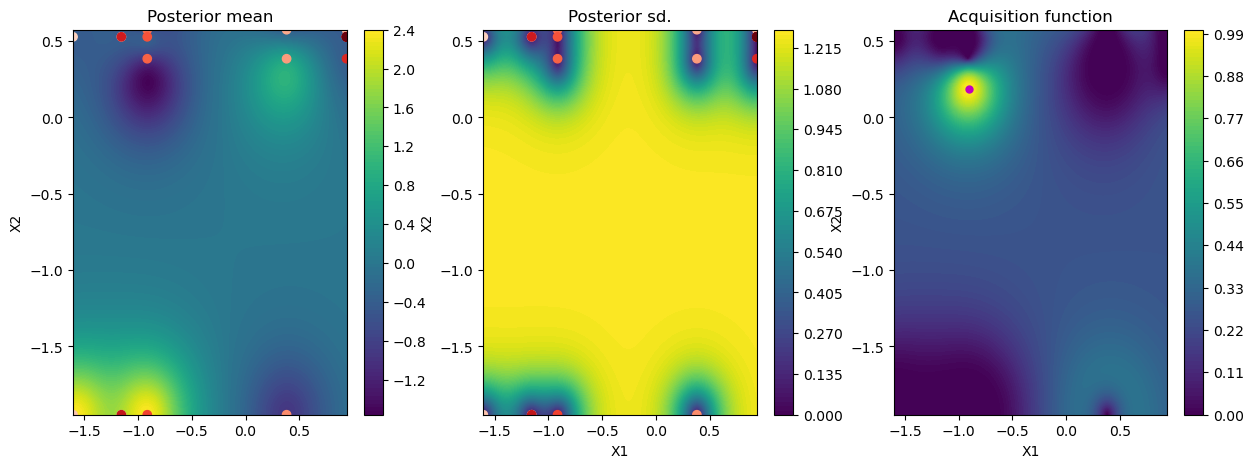

In [112]:
myBopt.plot_acquisition()

In [113]:
x1_mesh, x2_mesh = np.meshgrid(x1_ystat, x2_ystat)
x1_mesh_std = (x1_mesh - mean_X[0]) / sd_X[0]
x2_mesh_std = (x2_mesh - mean_X[1]) / sd_X[1]

In [114]:
X_mesh = np.hstack((x1_mesh_std.reshape(N_pos*N_AA,1),x2_mesh_std.reshape(N_pos*N_AA,1)))

In [115]:
acqu_value = - myBopt.acquisition.acquisition_function(X_mesh).reshape((N_AA, N_pos)).T

In [116]:
acqu_value_not_yet_sampled = acqu_value * (1 - Y_sampled_flag)#Set the values of the already sampled points to 0

In [117]:
candidates5 = top_n_indices(acqu_value_not_yet_sampled, 5)

In [118]:
can_position = SS_position[candidates5[0][0]]

In [119]:
can_AA = SS_AminoAcid[candidates5[0][1]] 

In [120]:
print('SUGGEST      position:', can_position, ',    AA:',can_AA)

SUGGEST      position: 110 ,    AA: R
